# MCMC sampling with transformed coordinates

In this example we want to compute

$$ I = \int_0^2 dx \, \rho(x) \, g(x) $$

where $ \rho(x) = x/2 $ and $ g(x) = 2 x $.

Analytically $ I = \int_0^2 dx \, x^2 = \frac{8}{3} \simeq 2.66666667 $.

The idea is to proceed with a standard MCMC integration, but modify $ \rho $ by nesting a transformation of coordinates $ t $:

$$ I = \int_{t^{-1}(0)}^{t^{-1}(2)} dx \, \rho(t(x)) \, g(t(x)) \, \frac{dt}{dx}|_{x} $$

If we want to account for the fact that $ \rho(t(x)) $ is most likely not normalized:

$$ I = \int_{t^{-1}(0)}^{t^{-1}(2)} dx \, \frac{\rho(t(x))}{\int_{t^{-1}(0)}^{t^{-1}(2)} dx \, \rho(t(x))} \, g(t(x)) \, \frac{dt}{dx}|_{x} \, (\int_{t^{-1}(0)}^{t^{-1}(2)} dx \, \rho(t(x))) $$

To experiment with it, we will take

$$ t(x) = 3 \, x^2 $$

therefore:

$$ I = \int_0^{\sqrt{2/3}} dx \, \frac{\frac{3 \, x^2}{2}}{27 \, \sqrt{2}} \, 36 x^3 \, \frac{\sqrt{2}}{3 \sqrt{3}} $$

$$ I = \int_0^{\sqrt{2/3}} dx \, \frac{\frac{3 \, x^2}{2}}{27 \, \sqrt{2}} \, \frac{12 \sqrt{2} x^3}{\sqrt{3}} $$

Notice that $t$ is not injective on $\mathbb{R}$, therefore $t^{-1}$ is not well defined. To get around this, we limit the domain to $\mathbb{R}^{+}$. Therefore the integration range $[0, \sqrt{2/3}]$ is justified.

In the following we compute the integral above to verify that there are no mistakes in the math derivation.

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

## Set the integration parameters and functions

In [2]:
num_warming_steps = 500
num_samples = 100000
# target_log_prob_fn = tfp.distributions.Triangular(low=0.0, high=2.0, peak=2.).log_prob

g = lambda x: 2. * x
transform = lambda x: 3. * x * x
rho = tfp.distributions.Triangular(low=0.0, high=2.0, peak=2.).prob
transformed_rho = lambda x: rho(transform(x)) if x > 0 else rho(0)
log_of_rho = tfp.distributions.Triangular(low=0.0, high=2.0, peak=2.).log_prob
log_of_transformed_rho = lambda x: tf.constant(log_of_rho(transform(x))) if x > 0 else tf.constant(log_of_rho(transform(0. * x)))

corrected_g = lambda x: 12. * np.sqrt(2) * x * x * x / np.sqrt(3)

## Visual inspections

### Transformation curve

<AxesSubplot:xlabel='x'>

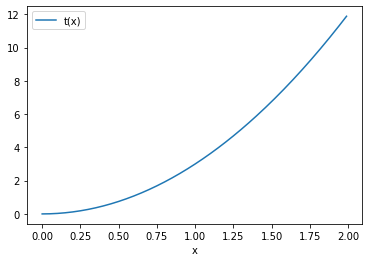

In [3]:
x = [_x for _x in np.arange(0., 2., 0.01)]
t = [transform(_x) for _x in x]

pd.DataFrame({'x': x, 't(x)': t}).set_index('x').plot()

### Transformation of $\rho$

<AxesSubplot:xlabel='x'>

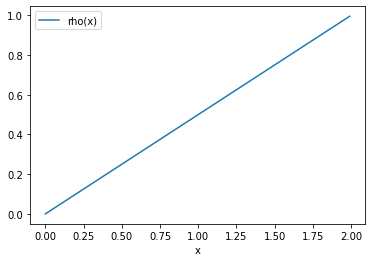

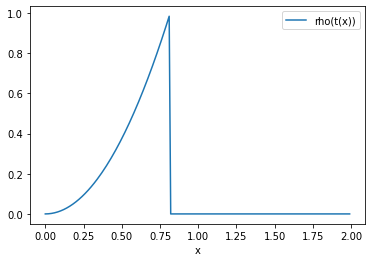

In [4]:
ty = [rho(_x).numpy() for _x in x]
pd.DataFrame({'x': x, 'rho(x)': ty}).set_index('x').plot()

y = [transformed_rho(_x).numpy() for _x in x]
pd.DataFrame({'x': x, 'rho(t(x))': y}).set_index('x').plot()

<AxesSubplot:xlabel='x'>

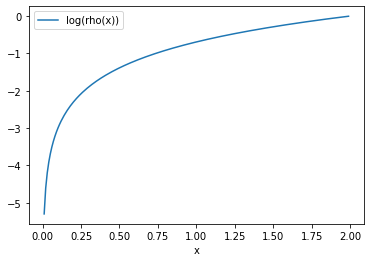

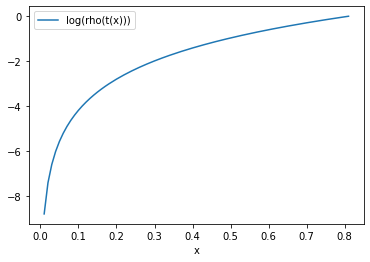

In [5]:
ty = [log_of_rho(_x).numpy() for _x in x]
pd.DataFrame({'x': x, 'log(rho(x))': ty}).set_index('x').plot()

y = [log_of_transformed_rho(_x).numpy() for _x in x]
pd.DataFrame({'x': x, 'log(rho(t(x)))': y}).set_index('x').plot()

## MCMC Integration

We will neglect autocorrelations when computing the integral uncertainty.

In [6]:
kernel = tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn=log_of_transformed_rho)

In [7]:
%%time

samples = tfp.mcmc.sample_chain(
  num_results=num_samples,
  current_state=0.4 * tf.ones(1),
  kernel=kernel,
  num_burnin_steps=0,
  trace_fn=None)

CPU times: user 6min 13s, sys: 3.32 s, total: 6min 16s
Wall time: 6min 33s


In [8]:
samples = tf.reshape(samples, [num_samples])
samples[0:3]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.4, 0.4, 0.4], dtype=float32)>

Visual inspection of the distribution of $x$:

In [9]:
df = pd.DataFrame({'x': samples.numpy()})
fig = px.histogram(df, x='x')
fig.write_image("images/mcmc.jpg")

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('images/mcmc.jpg'))
plt.show()

We can see that the distribution is no more linear, but quadratic, as expected. We can also notice that the domain is from $0$ to $\sqrt{2/3}$.

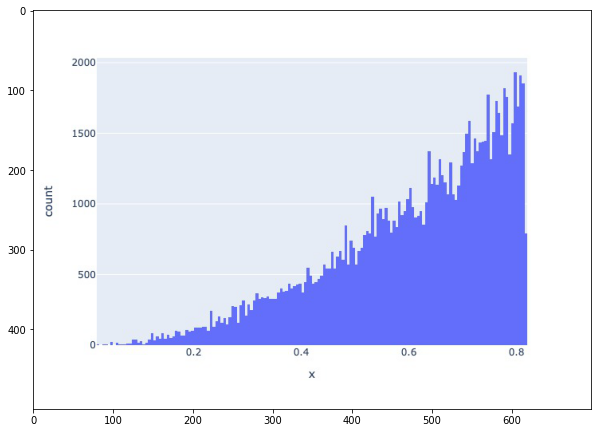

In [10]:
values = corrected_g(samples)
values[0:5]

We can see that the distribution is no more linear, but quadratic, as expected. We can also notice that the domain is from $0$ to $\sqrt{2/3}$.

In [11]:
values = corrected_g(samples)
values[0:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.62706935, 0.62706935, 0.62706935, 0.62706935, 0.62706935],
      dtype=float32)>

In [12]:
print(f'Integral = { tf.math.reduce_mean(values) } +- { tf.math.reduce_std(values)/np.sqrt(num_samples) }')

Integral = 2.6447300910949707 +- 0.004914226941764355
